In [3]:
import torch
from d2l import torch as d2l
%matplotlib inline

In [2]:
x = torch.arange(12, dtype=torch.uint8)
x

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=torch.uint8)

In [3]:
x = torch.randn((2,3,2))
x

tensor([[[ 0.1244,  2.3171],
         [ 0.3459,  1.9046],
         [ 0.9836, -0.3275]],

        [[-1.0538,  0.4079],
         [ 0.4406,  0.1378],
         [-0.2462,  0.5620]]])

In [4]:
sin_x = torch.cos(x)
cos_x = torch.sin(x)
torch.cat((sin_x, cos_x), dim=2)

tensor([[[ 0.9923, -0.6790,  0.1241,  0.7342],
         [ 0.9408, -0.3276,  0.3391,  0.9448],
         [ 0.5541,  0.9469,  0.8325, -0.3216]],

        [[ 0.4943,  0.9180, -0.8693,  0.3967],
         [ 0.9045,  0.9905,  0.4265,  0.1374],
         [ 0.9698,  0.8462, -0.2438,  0.5329]]])

In [5]:
before = id(cos_x)
cos_x[:] = cos_x+sin_x
before == id(cos_x)

True

In [6]:
x = torch.arange(4, dtype=torch.float32)
x.requires_grad_(True)
x, x.grad

(tensor([0., 1., 2., 3.], requires_grad=True), None)

In [7]:
y = 2 * torch.dot(x , x)
y

tensor(28., grad_fn=<MulBackward0>)

In [8]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [35]:
x.grad.zero_()
x.grad

tensor([0., 0., 0., 0.])

In [36]:
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [53]:
x = torch.tensor([1.,2.], requires_grad=True)
y = torch.empty(3)
y[0] = 3*x[0]**2
y[1] = x[0]**2+2*x[1]*2
y[2] = 10*x[1]
y.backward(torch.tensor([1., 1., 1.]))
x.grad

tensor([ 8., 14.])

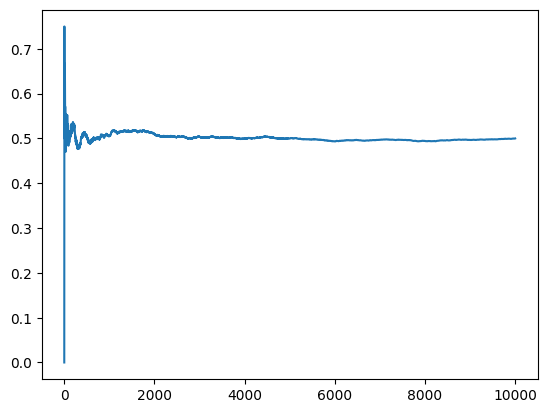

In [167]:
counts = Multinomial(1, 
    torch.tensor([0.5, 0.5])).sample((10_000,))
cumcounts = counts.cumsum(dim=0)
estimates = cumcounts / cumcounts.sum(dim=1, keepdims=True)

fig, ax = plt.subplots()
fig = plt.plot(estimates.numpy()[:, 0])

In [170]:
n = 10_000
a = torch.ones(n)
b = torch.ones(n)

In [174]:
c = torch.zeros(n)
t = time.time()
for iii in range(n):
    c = a[iii]+b[iii]
print(time.time()-t)
t = time.time()
c = a+b
print(time.time()-t)

0.4384174346923828
0.0009355545043945312


In [205]:
#@add_to_class(A)
#def do(self):
#    print(f"self.b = {self.b}")

#class B(d2l.HyperParameters):
#    def __init__(self, a, b, c):
#        self.save_hyperparameters(ignore=['c'])

In [11]:
class LinearRegressionScratch(d2l.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs,1),
                             requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

def addtoclass(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [14]:
@addtoclass(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w)+self.b

@addtoclass(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = ( ( y_hat - y )**2 ) / 2
    return l.mean()


In [26]:
class SGD(d2l.HyperParameters):
    def __init__(self, params, lr):
        self.save_hyperparameters()
        
    def step(self):
        for param in self.params:
            param -= param.grad*self.lr
            
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [22]:
@addtoclass(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [19]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    #usually where you would warm the gpu
    return batch

In [20]:
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

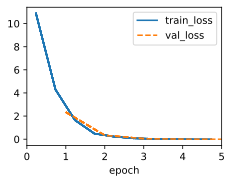

In [31]:
model = LinearRegressionScratch(2, lr=0.03) #initialize parameter
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
#for comparison with the settled value of the model
trainer = d2l.Trainer(max_epochs=3)
#divide into batches, find d(data)/dw, adjust weights, repeat
trainer.fit(model, data)

In [32]:
print(data.w - model.w.reshape(data.w.shape))
print(data.b - model.b)

tensor([ 0.0147, -0.0281], grad_fn=<SubBackward0>)
tensor([0.0297], grad_fn=<RsubBackward1>)


In [79]:
from torch import nn
import matplotlib.pyplot as plt
errors = []
num_params = []

In [115]:
class LinearRegression(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1) #specifiy only output dimension
        self.net.weight.data.normal_(0, 0.01) #mean, sigma
        self.net.bias.data.fill_(0)

In [116]:
@d2l.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X) 
    #push feature dataset on weights and return loss

In [117]:
@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

In [118]:
@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

In [139]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, lr, wd):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

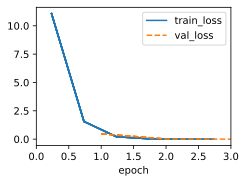

In [159]:
param_count = 10
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.rand(param_count),
                                  b = 4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Function accuracy: 0.12965452671051025


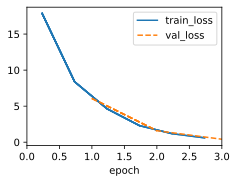

In [169]:
model = WeightDecay(wd=-0.2, lr=0.01)
trainer.fit(model, data)
print(f"Function accuracy: {data.w.norm()-model.get_w_b()[0].norm()}")

In [107]:
@d2l.add_to_class(LinearRegression)
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

In [110]:
print(f"Error in estimating w: {data.w - w.reshape(data.w.shape)}")
print(f"Error in estimating b: {data.b - b}")


Error in estimating w: tensor([ 1.0504e-03,  1.4132e-04,  1.7279e-04, -5.0008e-05,  6.0987e-04,
         5.7197e-04, -2.6739e-04,  1.0133e-04,  1.0356e-04, -1.2279e-04])
Error in estimating b: tensor([0.0003])


In [210]:
import torchvision
from torchvision import transforms
import time

class FashionMNIST(d2l.DataModule):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

In [222]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)

(60000, 10000)

In [213]:
@d2l.add_to_class(FashionMNIST)
def text_labels(self, indices):
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

In [214]:
@d2l.add_to_class(FashionMNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

In [219]:
@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

time to load: 0.52


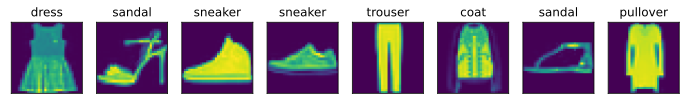

In [224]:
tic = time.time()
batch = next(iter(data.train_dataloader()))
print(f"time to load: {time.time()-tic:0.2f}")
data.visualize(batch)

In [ ]:
##BASE CLASSIFICATION MODEL

In [225]:
class Classifier(d2l.Module):
    def validation_step(self, validation_batch):
        Y_hat = self(*validation_batch[:-1])
        self.plot('loss', self.loss(Y_hat, validation_batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

In [226]:
@d2l.add_to_class(d2l.Module)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

In [227]:
@d2l.add_to_class(Classifier)  #@save
def accuracy(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

In [1]:
def softmax(X):
    exp = torch.exp(X)
    partition = exp.sum(1, keepdims=True)
    return exp/partition #partition is broadcasted

In [6]:
X = torch.rand(2,5)
X_prob = softmax(X)
X, X_prob.sum(1)

(tensor([[0.2611, 0.8316, 0.8058, 0.8291, 0.7094],
         [0.4112, 0.5841, 0.1088, 0.6390, 0.2908]]),
 tensor([1.0000, 1.0000]))